In [ ]:
!pip install -q livelossplot
!pip install phantominator

     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
from jax.scipy import ndimage
from jax.experimental import optimizers, stax
import random as py_random
import numpy

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import requests
from skimage.transform import radon, rescale
from io import BytesIO


import cv2
import scipy.ndimage
from scipy.special import binom

from tqdm.notebook import tqdm as tqdm
import numpy as onp

from phantominator import shepp_logan, ct_shepp_logan, ct_modified_shepp_logan_params_2d

## Random seed
rand_key = random.PRNGKey(56)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#resolution
RES = 512

In [ ]:
def get_shepp_dataset(rand_key):

    ct_params = np.array(ct_modified_shepp_logan_params_2d())
    i_ct_params = ct_params + random.normal(rand_key, shape=ct_params.shape)/20.0
    return np.clip(ct_shepp_logan((RES,RES), E=i_ct_params), 0.0, 1.0)

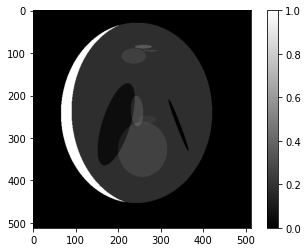

In [ ]:
visualize = True #@param {type:"boolean"}

#@markdown Shepp Dataset
load_shepp = True #@param {type:"boolean"}

phantom = get_shepp_dataset(rand_key)

x1 = np.linspace(0, 1, RES+1)[:-1] # use full image resolution 
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)
x_test = x_train

def plot_dataset(phantom):
    plt.imshow(phantom, 'gray')
    plt.colorbar()
    plt.show()

plot_dataset(phantom)

        

In [ ]:
#@title Define ReLU Network

network_depth = 4 #@param
network_width = 256 #@param

def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(1))
  layers.append(stax.Sigmoid)
  return stax.serial(*layers)

init_fn, apply_fn = make_network(network_depth, network_width)

In [ ]:
#@title Embedding Definitions

embedding_size = 256 #@param

enc_dict = {}

input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                a * np.cos((2.*np.pi*x) @ b.T)], axis=-1) #/ np.linalg.norm(a) * np.sqrt(a.shape[0])

def compute_new_posenc(mres):
  bvals = 2.**np.linspace(0,mres,embedding_size//2) - 1.
  bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
  bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
  avals = np.ones((bvals.shape[0])) 
  return avals, bvals

def compute_basic():
  bvals = np.eye(2)
  avals = np.ones((bvals.shape[0])) 
  return avals, bvals

def visualize_encoders(enc_dict, keys=None):
    if keys is None:
        keys = enc_dict.keys()

    P = len(keys)
    plt.figure(figsize=(15,5))
    slices = {}
    for i, enc in enumerate(keys):
        plt.subplot(1,P,i+1)
        avals, bvals = enc_dict[enc]
        plt.scatter(bvals[:,0], bvals[:,1], marker='o', s=10, label=enc)
        plt.title(f'{enc} b values')
        plt.axis('equal')
    plt.show()

In [ ]:
@jit
def ct_project(img, theta):
    y, x = np.meshgrid(np.arange(int(img.shape[0]), dtype=np.float32)/int(img.shape[0]) - 0.5, np.arange(int(img.shape[1]), dtype=np.float32)/int(img.shape[1]) - 0.5, indexing='ij')
    x_rot = x*np.cos(theta) - y*np.sin(theta)
    y_rot = x*np.sin(theta) + y*np.cos(theta)
    x_rot = (x_rot + 0.5)*img.shape[1]
    y_rot = (y_rot + 0.5)*img.shape[0]
    sample_coords = np.stack([y_rot, x_rot], axis=0)
    resampled = ndimage.map_coordinates(img, sample_coords, 0).reshape(img.shape)
    return resampled.mean(axis=0)[:,None,...]

ct_project_batch = vmap(ct_project, (None, 0), 0)

In [ ]:
run_model = jit(lambda params, x: np.reshape(apply_fn(params, np.reshape(x, (-1, x.shape[-1]))), (x.shape[0], x.shape[1])))
compute_projs = jit(lambda params, x, thetas: ct_project_batch(run_model(params, x), thetas))
model_loss_proj = jit(lambda params, x, y, thetas: .5 * np.mean((compute_projs(params, x, thetas) - y) ** 2))
model_loss = jit(lambda params, x, y, thetas, image: .5 * np.abs(np.mean((np.clip(run_model(params, x), 0.0, 1.0) - image) ** 2)))
model_psnr = jit(lambda params, x, y, thetas, image: -10 * np.log10(2.*model_loss(params, x, y, thetas, image)))
model_grad_loss = jit(lambda params, x, y, thetas, image: grad(model_loss_proj)(params, x, y, thetas))

def train_model(lr, iters, train_data, test_data):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)



    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
    results = {
        'state': get_params(opt_state),
        'train_psnrs': model_psnr(get_params(opt_state), *train_data),
        'test_psnrs': model_psnr(get_params(opt_state), *test_data),
        'final_test' : run_model(get_params(opt_state), test_data[0])
    }
    return results

In [ ]:
params = {
    'shepp': {
        'lr': 1e-3,
        'no_enc_lr': 1e-2,
        'basic_lr': 1e-2,
        'gridopt_lr': 1e-1,
        'posenc_scale': 3,
        'gaussian_scale': 4,
    }
}

In [ ]:
training_steps =  1000#@param
num_thetas = 20#@param


thetas = np.linspace(0.0, np.pi, num_thetas+1)[:-1]

outputs = {}
target_distribution = 'shepp'

# no encoding
lr = params[target_distribution]['no_enc_lr']
outputs['no_encoding'] = []
# compute projections
y_train = ct_project_batch(phantom, thetas)
y_test = y_train # don't need extra projs for CT (performance is on recon.)
outputs['no_encoding'].append(train_model(lr, training_steps, 
                                          (x_train, y_train, thetas, phantom), 
                                          (x_test, y_test, thetas, phantom)))


# gaussian
bvals = random.normal(rand_key, (embedding_size, 2)) * params[target_distribution]['gaussian_scale']
avals = np.ones((bvals.shape[0])) 
lr = params[target_distribution]['lr']
outputs['gaussian'] = []
# compute projections
y_train = ct_project_batch(phantom, thetas)
y_test = y_train # don't need extra projs for CT (performance is on recon.)
train_data = (input_encoder(x_train, avals, bvals), y_train, thetas, phantom)
test_data = (input_encoder(x_test, avals, bvals), y_test, thetas, phantom)
outputs['gaussian'].append(train_model(lr, training_steps, train_data, test_data))








train iter:   0%|          | 0/1000 [00:00<?, ?it/s]

train iter:   0%|          | 0/1000 [00:00<?, ?it/s]

----------------------------------------
                  Test
----------------------------------------


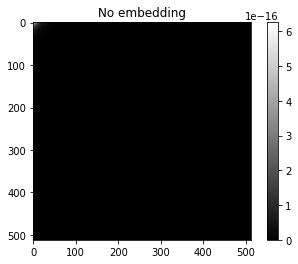

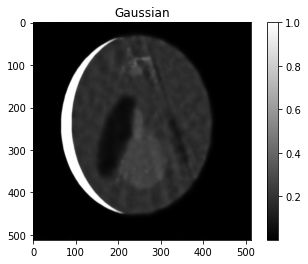

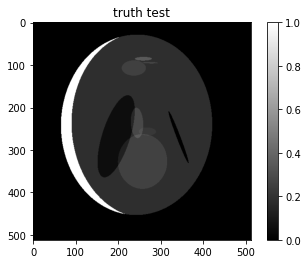

13.2456255
30.273724


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


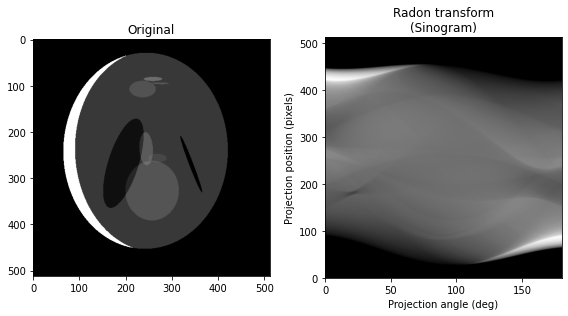

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


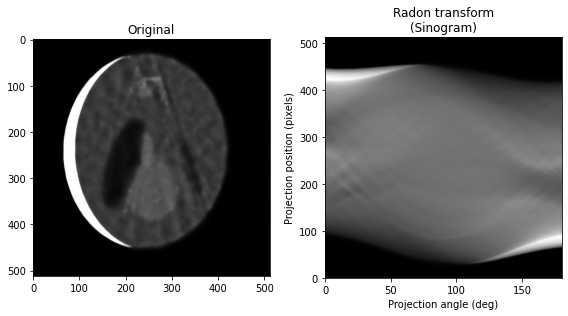

In [ ]:
print('----------------------------------------')
print('                  Test')
print('----------------------------------------')




plt.imshow(outputs['no_encoding'][0]['final_test'], 'gray')
plt.title('No embedding')
plt.colorbar()
plt.show()

plt.imshow(outputs['gaussian'][0]['final_test'], 'gray')
plt.title('Gaussian')
plt.colorbar()
plt.show()


plt.imshow(phantom, 'gray')
plt.title('truth test')
plt.colorbar()
plt.show()

print(outputs['no_encoding'][0]['train_psnrs'])
print(outputs['gaussian'][0]['train_psnrs'])

def plotSinogram(img):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
  ax1.set_title("Original")
  ax1.imshow(img, cmap=plt.cm.Greys_r)
  theta = np.linspace(0., 180., max(img.shape), endpoint=False)
  imgcpy = numpy.copy(img)
  sinogram = radon(imgcpy, theta=theta)
  dx, dy = 0.5 * 180.0 / max(imgcpy.shape), 0.5 / sinogram.shape[0]
  ax2.set_title("Radon transform\n(Sinogram)")
  ax2.set_xlabel("Projection angle (deg)")
  ax2.set_ylabel("Projection position (pixels)")
  ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
            extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
            aspect='auto')
  fig.tight_layout()
  plt.show()
plotSinogram(phantom)
plotSinogram(outputs['gaussian'][0]['final_test'])
#plt.plot(dar, 'gray')
#plt.title('truth test')
#plt.colorbar()
#plt.show()
